# 確率勾配法を用いた多クラスロジスティック回帰の実装

2次元データの3クラス分類問題を解く多クラスロジスティック回帰を実装する．
ここではサンプルを1つづつ用いる確率勾配法を実装する．

# 準備

In [ ]:
# load modules

import numpy as np

# !pip install scikit-image==0.12.3
# import skimage.data

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
# plt.gray();
plt.set_cmap(plt.cm.Paired);

import sklearn
# from sklearn.datasets import fetch_olivetti_faces
from sklearn.datasets import make_blobs

from ipywidgets import interact, interactive, fixed, RadioButtons
import ipywidgets as widgets
from IPython.display import display


<Figure size 432x288 with 0 Axes>

In [ ]:
!pip install autograd
import autograd.numpy as anp # autogradのnumpyの別名をanpにする
# from autograd import elementwise_grad as grad
from autograd import grad
from autograd import jacobian, hessian

In [ ]:
# check versions

print("sklearn version :", sklearn.__version__, " >= 0.18.0")
# print("skimage version :", skimage.__version__, " >= 0.12.0")
print("numpy version :", np.__version__, " >= 0.12.0")
print("matplotlib version:", matplotlib.__version__, ">= 2.0.0")

sklearn version : 0.22.2.post1  >= 0.18.0
numpy version : 1.19.5  >= 0.12.0
matplotlib version: 3.2.2 >= 2.0.0


# データセットの準備

sklearnのmake_blobで2次元データを準備する．
返り値は，データXとラベルyである．3クラスの場合，ラベルyは0,1,2で返ってくる．

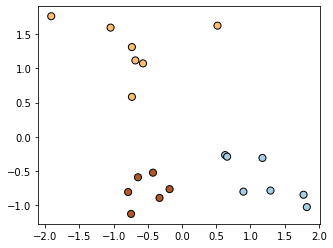

In [ ]:
X, y = make_blobs(n_samples=20, # 20個生成
                  n_features=2, # 2次元
                  centers=3,    # クラスタ中心2個
                  cluster_std = 2 # クラスタの大きさ（標準偏差）
                 )

X = np.hstack((X, np.ones((X.shape[0], 1)))) # 同次座標

# データの正規化
X[:, 0] -= X[:, 0].mean()
X[:, 1] -= X[:, 1].mean()
X[:, 0] /= X[:, 0].std()
X[:, 1] /= X[:, 1].std()


plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k');
plt.gca().set_aspect('equal');


0,1,2のラベルyをone-hotエンコードに変更する．

In [ ]:
y # これは0,12

array([0, 1, 1, 1, 2, 2, 0, 1, 0, 2, 1, 2, 1, 0, 2, 2, 0, 1, 0, 0])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
Y = OneHotEncoder(categories='auto').fit_transform(y.reshape(-1,1)).toarray()
Y # これでone-hotになっている

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

識別境界を直線で描くヘルパー関数の準備．

In [ ]:
# 境界線を引く関数の定義

def plotBoundary(X, net, w, mesh=True, n_neighbors=1):

    # plot range
    x_min = min(X[:,0])
    x_max = max(X[:,0])
    y_min = min(X[:,1])
    y_max = max(X[:,1])

    # visualizing decision function
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] # make a grid
    Z = np.zeros((XX.size, X.shape[1]))
    for i,xi in enumerate(np.c_[XX.ravel(), YY.ravel(), np.ones(XX.size)]):
        Z[i] = net(w, xi)
    Z = np.argmax(Z, axis=1) # --> 0,1,2
    Z = Z.reshape(XX.shape) # just reshape

    if mesh:
        plt.pcolormesh(XX, YY, Z, zorder=-10) # paint in 2 colors, if Z > 0 or not

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    

# 多クラスロジスティック回帰の実装

では多クラスロジスティック回帰（multinominal logistric regression, softmax regression）を実装する．

実装が正しいかどうかを確認するために，autogradでも実装しておく．

In [ ]:
W0 = np.random.rand(3, 3)

In [ ]:
# autogradによる実装．関数名に'a_'をつけておく．

def a_softmax(a):
    d = anp.exp(a).sum()
    return anp.exp(a) / d

def a_mlr(W, xi):
    """Multinominal Logistic Regression"""
    return a_softmax(W.T @ xi)

def g_a_mlr(W, xi, yi):
    """gradient of Multinominal Logistic Regression"""
    return anp.dot(xi.reshape(-1, 1), (a_softmax(anp.dot(W.T, xi)) - yi).reshape(1, -1))

def a_loss(W, xi, yi):
    fi = a_mlr(W, xi)
    loss = - yi[0] * anp.log(fi[0]) - yi[1] * anp.log(fi[1]) - yi[2] * anp.log(fi[2]) # cross entropy
    return loss

In [ ]:
# numpyによる実装

def softmax(a):
    d = np.exp(a).sum()
    return np.exp(a) / d

def mlr(W, xi):
    """Multinominal Logistic Regression"""
    return softmax(W.T @ xi)

def g_mlr(W, xi, yi):
    """gradient of Multinominal Logistic Regression"""
    return xi.reshape(-1, 1) @ (softmax(W.T @ xi) - yi).reshape(1, -1)

def loss(w, xi, yi):
    fi = mlr(w, xi)
    loss = - yi[0] * np.log(fi[0]) - yi[1] * np.log(fi[1]) - yi[2] * np.log(fi[2]) # cross entropy
    return loss

def loss01(w, xi, yi):
    """0-1 loss"""
    fi = mlr(w, xi)
    predicted_class = np.argmax(fi)
    loss = 1 - yi[predicted_class]
    return loss

ネットワークの出力と勾配の出力を確かめる（デバッグ）．

In [ ]:
i = np.random.randint(len(y))
print(i)
X[i], Y[i]

10


(array([-0.68207743,  1.11594753,  1.        ]), array([0., 1., 0.]))

In [ ]:
xi = X[i]
print(mlr(W0, xi))
print(a_mlr(W0, xi))

[0.48113965 0.33741857 0.18144177]
[0.48113965 0.33741857 0.18144177]


In [ ]:
yi = Y[i]

In [ ]:
print(g_mlr(W0, xi, yi))
print(g_a_mlr(W0, xi, yi))

[[-0.3281745   0.45193184 -0.12375734]
 [ 0.53692661 -0.73940611  0.2024795 ]
 [ 0.48113965 -0.66258143  0.18144177]]
[[-0.3281745   0.45193184 -0.12375734]
 [ 0.53692661 -0.73940611  0.2024795 ]
 [ 0.48113965 -0.66258143  0.18144177]]


In [ ]:
print(loss(W0, xi, yi))
print(a_loss(W0, xi, yi))

1.0864310661053076
1.0864310661053076


以下では，サンプルを先頭から順番に一つずつ用いて，SGDの更新則を適用する．
サンプルは3色のクラスに分かれている．

In [ ]:
W = W0.copy()

In [ ]:
val_start = 0 # スライドバーの最小値
val_end   = len(y)-1 # スライドバーの最大値
val_step  = 1 # スライドバーはこの値ずつ増える
val_default = 0 # スライドバーの初期値


@interact(sample=(val_start, val_end, val_step)) # この行が関数の直前に必要
def g(sample=val_default): # この関数を毎回呼び出す    
    
    global W
    
    if sample > len(y)-1:
        return

    plt.scatter(X[:, 0], X[:, 1], marker='o', s=50, c=y, edgecolors='k')
    plt.scatter(X[sample, 0], X[sample, 1], marker='o', s=90, facecolors='none',  edgecolors='k')
   
    plotBoundary(X, mlr, W)
    
    xi = X[sample]
    yi = Y[sample]

   
    plt.gca().set_aspect('equal');
    plt.show()

    # 更新則
    alpha = 0.01
    W = W - alpha * g_mlr(W, xi, yi)

    

interactive(children=(IntSlider(value=0, description='sample', max=19), Output()), _dom_classes=('widget-inter…

- 以下ではステップサイズalphaに加えて，慣性項betaを変更する．
- また01-損失も計算し，最小化している目的関数である交差エントロピー損失と比較する．
- 更に，エポックを設定し，スライドバーを延々と動かし続けられるようにする．
- またミニバッチ学習のbatch_sizeを設定する（1ならSGD）．実装では，勾配を蓄積してbatch_size回だけ溜まったら更新することにしている

In [ ]:
W = W0.copy()

In [ ]:
N = len(y)
epochs = 100
max_iter = N * epochs - 1

val_start = 0 # スライドバーの最小値
val_end   = max_iter # スライドバーの最大値
val_step  = 1 # スライドバーはこの値ずつ増える
val_default = 0 # スライドバーの初期値

loss_val = []
loss01_val = []

d = np.zeros_like(W)
grad = np.zeros_like(W)
batch_size = 2
batch_index = 0

@interact(sample=(val_start, val_end, val_step),
          alpha=[1.0, 0.1, 0.05, 0.01, 0.001],
          beta=[0, 0.5, 0.9, 0.99],
          batch_size=(1, N),
          )
def g(sample=val_default, alpha=0.1, beta=0.9, batch_size=1):
    
    global W, d, grad, batch_index

    xi = X[sample % N]
    yi = Y[sample % N]

    grad += g_mlr(W, xi, yi)

    batch_index += 1
    if batch_index >= batch_size:    

        # 更新則
        d = beta * d + (1 - beta) * grad  # beta=0なら慣性項を使わない
        W = W - alpha * grad

        grad *= 0  # zero_grad
        batch_index = 0

        plt.scatter(X[:, 0], X[:, 1], marker='o', s=50, c=y, edgecolors='k')
        plt.scatter(X[sample % N, 0], X[sample % N, 1], 
                    marker='o', s=90, facecolors='none',  edgecolors='k')
        plotBoundary(X, mlr, W)
        plt.gca().set_aspect('equal');
        plt.show()

        loss_val.append(sum([loss(W, xi, yi) for xi, yi in zip(X, Y)])) # loss for all samples
        loss01_val.append(sum([loss01(W, xi, yi) for xi, yi in zip(X, Y)])) # loss for all samples
        plt.plot(loss_val, label='loss')
        plt.plot(loss01_val, label='01-loss')
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.legend()
        plt.show()

interactive(children=(IntSlider(value=0, description='sample', max=1999), Dropdown(description='alpha', index=…

# 顔画像の識別


ここではsklearnのデータセットとして準備されているOlivetti facesデータセットを用いる．
詳しくは[sklearnのマニュアル](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html)を参照．

このデータセットには400枚の顔画像があり，それぞれが4096次元のベクトルである（64x64画像を表す）．
人物は40人であり，各人物の画像が10枚ずつある．

In [ ]:
import sklearn
from sklearn.datasets import fetch_olivetti_faces


# load the face dataset

dataset = fetch_olivetti_faces(shuffle=False)
X = dataset.data
y = dataset.target

ラベル'y'は人物番号になっているので，one-hotエンコーディングに変更する．

In [ ]:
from sklearn.preprocessing import OneHotEncoder
Y = OneHotEncoder(categories='auto').fit_transform(y.reshape(-1,1)).toarray()
Y # これでone-hotになっている

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

このデータを学習用と検証用に8:2に分割する．

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1, 
                            train_size=0.8,  # training
                            test_size=0.2,  # validation
                            random_state=0)

train_index, val_index = next(ss.split(X, Y))

X_train, X_val = X[train_index], X[val_index]
Y_train, Y_val = Y[train_index], Y[val_index]  # one-hot encoding
y_train, y_val = y[train_index], y[val_index]  # label

stratifiedサンプリングにより，各クラスを学習用と検証用に分けている．インデックスを見て確認する．

In [ ]:
np.sort(y_train), np.sort(y_val)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
         2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
         8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
        10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
        12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14,
        14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16,
        17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19,
        19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21,
        21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23,
        23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25,
        25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27,
        27, 

In [ ]:
X_train.shape, Y_train.shape

((320, 4096), (320, 40))

では学習ループを回す．
- バッチサイズ8
- 学習率（ステップサイズ）alpha 0.01
- 慣性項 beta 0.99
- 20エポック
- 5エポックごとにalphaを半分にする
- バッチで更新した時点の損失を計算
- エポック毎に認識率を計算

In [ ]:
from tqdm.notebook import tqdm

N = len(X_train)
n_epochs = 20

loss_train = []
loss_val = []
acc_train = []
acc_val = []

W = np.random.rand(X_train.shape[1], Y_train.shape[1]) / 10000

d = np.zeros_like(W)
grad = np.zeros_like(W)
batch_size = 8

alpha = 0.01
beta = 0.99

with tqdm(range(n_epochs)) as pbar_epoch:
    for epoch in pbar_epoch:
        pbar_epoch.set_description("[Epoch %d]" % (epoch))

        batch_index = 0

        with tqdm(enumerate(zip(X_train, Y_train)),
                  total=N,
                  leave=False) as pbar_loss:
            for bi, (xi, yi) in pbar_loss:

                grad += g_mlr(W, xi, yi)

                batch_index += 1
                if batch_index >= batch_size:    

                    # 更新則
                    d = beta * d + (1 - beta) * grad  # beta=0なら慣性項を使わない
                    W = W - alpha * grad

                    grad *= 0  # zero_grad
                    batch_index = 0

                    loss_train.append(sum([loss(W, xi, yi) for xi, yi in zip(X_train, Y_train)]) / len(y_train))
                    loss_val.append(sum([loss(W, xi, yi) for xi, yi in zip(X_val, Y_val)]) / len(y_val))
                
                if len(loss_train) > 0:
                    pbar_loss.set_postfix_str("loss train={:.4f} val={:.4f}".format(loss_train[-1], loss_val[-1]))


        # validation
        acc_train.append(sum(np.argmax(X_train @ W, axis=1) == y_train) / len(y_train))
        acc_val.append(sum(np.argmax(X_val @ W, axis=1) == y_val) / len(y_val))
        pbar_epoch.set_postfix_str("acc train={:.4f} val={:.4f}".format(acc_train[-1], acc_val[-1]))

        if epoch % 5 == 0:
            alpha *= 0.5

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

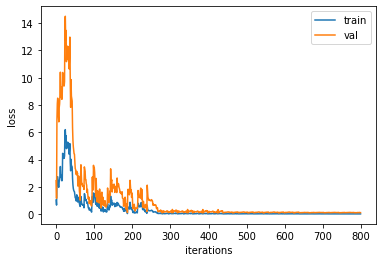

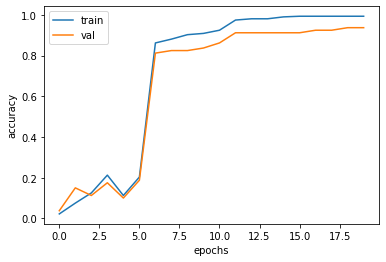

In [ ]:
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

plt.plot(acc_train, label='train')
plt.plot(acc_val, label='val')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()